In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# Save references to each table
print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
most_recent_date

'2017-08-23'

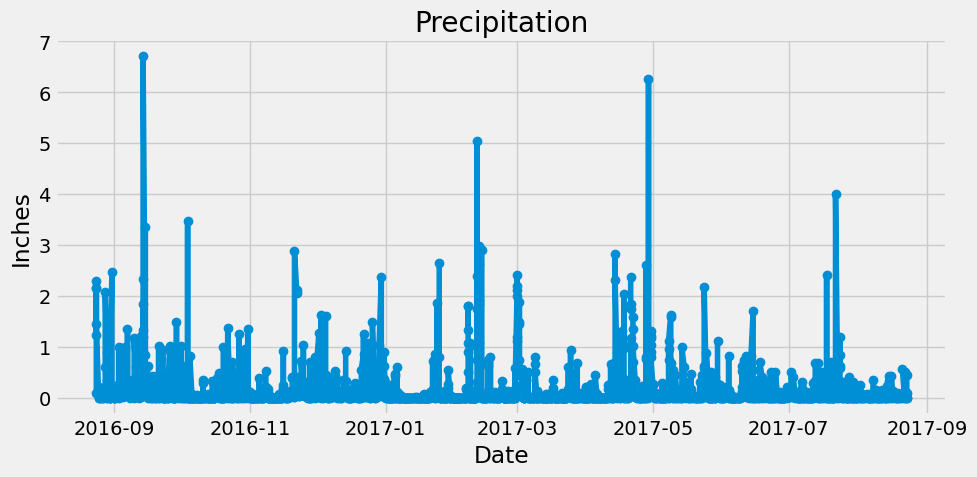

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()

# Print the summary statistics
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()

total_stations_count = total_stations[0][0]

total_stations_count

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

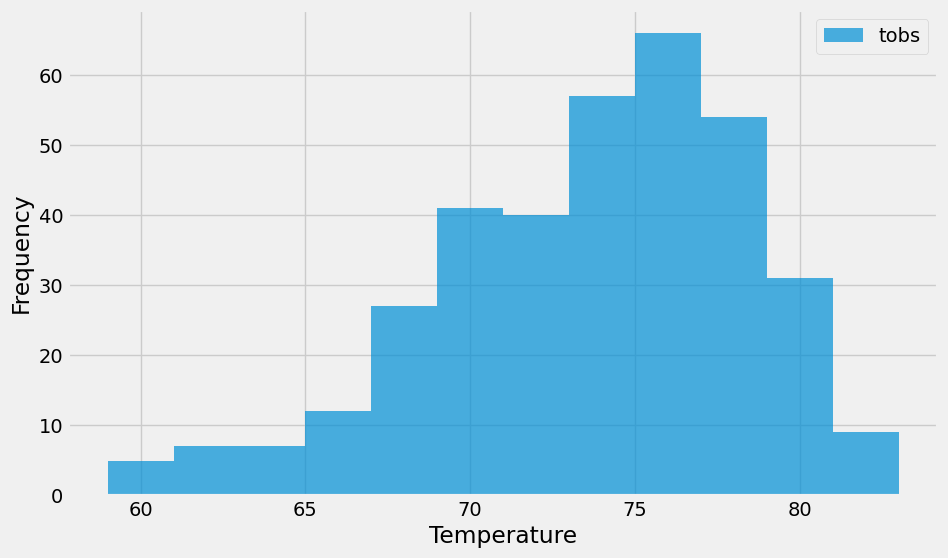

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_date = datetime.strptime('2017-08-18', '%Y-%m-%d')
last_year_date = max_date - timedelta(days=365)

results = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= last_year_date,
    Measurement.date <= max_date
).all()

# Convert results to a DataFrame
df = pd.DataFrame(results, columns=['date', 'tobs'])

#Plot histogram
plt.figure(figsize=(10, 6))
df['tobs'].plot(kind='hist', bins=12, alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


# Close Session

In [54]:
# Close Session
session.close()